In [1]:
include("../../src/CoherentStructures.jl") #this is terrible but neccessary during development (?)

Main.CoherentStructures

In [2]:
using StreamMacros, Main.CoherentStructures
using Tensors, Arpack, JLD2, OrdinaryDiffEq
using Plots
using OrdinaryDiffEq
const ODE = OrdinaryDiffEq

OrdinaryDiffEq

In [3]:
JLD2.@load("Ocean_geostrophic_velocity.jld2");
UV = interpolateVF(Lon, Lat, Time, UT, VT);

In [4]:
# Parameters
grid_resolution        = 100
quadrature_order       = 1
t_initial              = minimum(Time)
t_end                  = t_initial+80
scale                  = 1;

In [5]:
LL, UR = (-4.0, -34.0), (6.0, -28.0)
ctx, _ = regularTriangularGrid((grid_resolution, Integer(floor((UR[2] - LL[2])/(UR[1] - LL[1])*grid_resolution))), 
        LL, UR, quadrature_order = quadrature_order);

In [6]:
function evaluate_on_grid(f,ctx)
    [f(node.x) for node in ctx.grid.nodes]
end

evaluate_on_grid (generic function with 1 method)

In [7]:
function l1_error(reference,solution)
    sum(sum([abs.(a .- b) for (a,b) in zip(reference,solution)])) / (2*length(reference))
end

l1_error (generic function with 1 method)

In [8]:
function l2_error(reference,solution)
    sum(sqrt.(sum([(a .- b).^2 for (a,b) in zip(reference,solution)]))) / (2*length(reference))
end

l2_error (generic function with 1 method)

In [9]:
function linfty_error(reference,solution)
    sum(maximum([(a .- b) for (a,b) in zip(reference,solution)]))
end

linfty_error (generic function with 1 method)

In [10]:
function T(solver, stepsize)
    return (x, param) -> flow(interp_rhs, x, [t_initial, t_end + scale*param], p=UV,
        dt=stepsize,adaptive=false,solver=solver)[end]
end

T (generic function with 1 method)

In [11]:
function Tdot_reference(solver, stepsize, param)
   return x -> UV(T(solver, stepsize)(x,param)...,t_end+param)*scale
end

Tdot_reference (generic function with 1 method)

In [12]:
function Tdot_autodiff(solver, stepsize, param)
    return x -> Main.CoherentStructures.parameter_autodiff(T(solver, stepsize), x, param)
end

Tdot_autodiff (generic function with 1 method)

In [13]:
function Tdot_finite_differences(solver, stepsize, param, diff)
    return x -> 
     (T(solver, stepsize)(x, param+diff) .- T(solver, stepsize)(x, param-diff)) ./ (2*diff)
end

Tdot_finite_differences (generic function with 1 method)

In [14]:
stepsize_range_BS5 = [6,5,2.5,1,0.75,0.6,0.5,0.4,0.25,0.1,0.075,0.05,0.025,0.01];

In [15]:
@time reference_BS5 = [evaluate_on_grid(Tdot_reference(OrdinaryDiffEq.BS5(),stepsize,0),ctx) 
    for stepsize in stepsize_range_BS5];

 71.229718 seconds (48.92 M allocations: 2.856 GiB, 1.40% gc time)


In [16]:
@time autodiff_BS5    = [evaluate_on_grid(Tdot_autodiff(OrdinaryDiffEq.BS5(),stepsize,0),ctx) 
    for stepsize in stepsize_range_BS5]
@time FD_1eminus2_BS5 = [evaluate_on_grid(Tdot_finite_differences(OrdinaryDiffEq.BS5(),stepsize,0,1e-2),ctx)
    for stepsize in stepsize_range_BS5]
@time FD_1eminus3_BS5 = [evaluate_on_grid(Tdot_finite_differences(OrdinaryDiffEq.BS5(),stepsize,0,1e-3),ctx)
    for stepsize in stepsize_range_BS5]
@time FD_1eminus4_BS5 = [evaluate_on_grid(Tdot_finite_differences(OrdinaryDiffEq.BS5(),stepsize,0,1e-4),ctx) 
    for stepsize in stepsize_range_BS5]
@time FD_1eminus5_BS5 = [evaluate_on_grid(Tdot_finite_differences(OrdinaryDiffEq.BS5(),stepsize,0,1e-5),ctx)
    for stepsize in stepsize_range_BS5];
@time FD_1eminus6_BS5 = [evaluate_on_grid(Tdot_finite_differences(OrdinaryDiffEq.BS5(),stepsize,0,1e-6),ctx)
    for stepsize in stepsize_range_BS5];
@time FD_1eminus7_BS5 = [evaluate_on_grid(Tdot_finite_differences(OrdinaryDiffEq.BS5(),stepsize,0,1e-7),ctx)
    for stepsize in stepsize_range_BS5];

209.717407 seconds (26.53 M allocations: 1.598 GiB, 0.18% gc time)
117.140232 seconds (7.69 M allocations: 818.759 MiB, 0.12% gc time)
116.231402 seconds (7.45 M allocations: 805.193 MiB, 0.11% gc time)
116.119346 seconds (7.45 M allocations: 805.194 MiB, 0.11% gc time)
115.515705 seconds (7.45 M allocations: 805.193 MiB, 0.11% gc time)
116.158623 seconds (7.45 M allocations: 805.199 MiB, 0.09% gc time)
116.182264 seconds (7.45 M allocations: 805.194 MiB, 0.11% gc time)


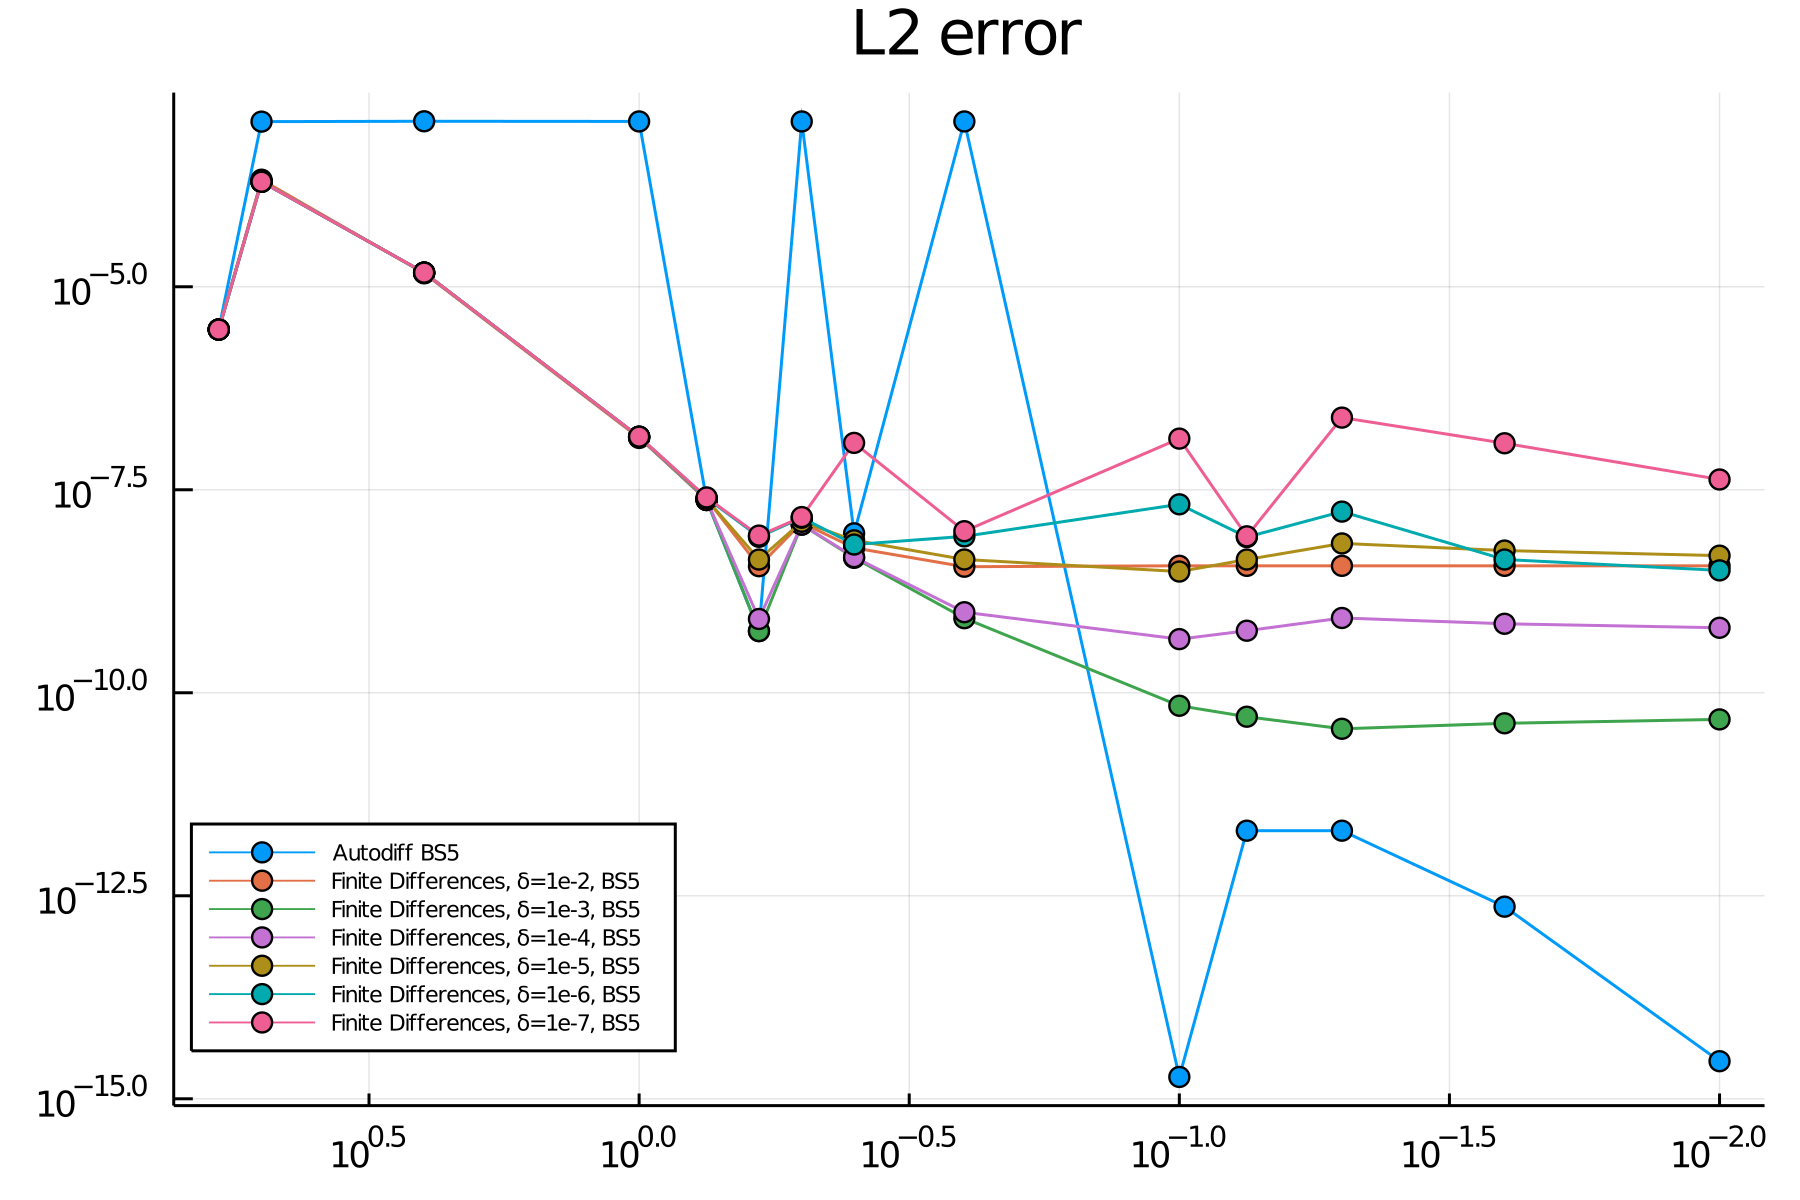

In [17]:
l2_plot_BS5 = Plots.plot(stepsize_range_BS5,[l2_error(ref_stepsize,stepsize) 
        for (ref_stepsize,stepsize) in zip(reference_BS5,autodiff_BS5)], 
    xaxis=:log, yaxis=:log, marker=:dot, xflip=true, label="Autodiff BS5"
    ,fmt=:png,dpi=300,title="L2 error",legend=(0.1,0.25),legendfontsize=5)
Plots.plot!(stepsize_range_BS5,[l2_error(ref_stepsize,stepsize) 
        for (ref_stepsize,stepsize) in zip(reference_BS5,FD_1eminus2_BS5)], 
    marker=:dot, label="Finite Differences, δ=1e-2, BS5")
Plots.plot!(stepsize_range_BS5,[l2_error(ref_stepsize,stepsize) 
         for (ref_stepsize,stepsize) in zip(reference_BS5,FD_1eminus3_BS5)], 
    marker=:dot, label="Finite Differences, δ=1e-3, BS5")
Plots.plot!(stepsize_range_BS5,[l2_error(ref_stepsize,stepsize) 
         for (ref_stepsize,stepsize) in zip(reference_BS5,FD_1eminus4_BS5)], 
    marker=:dot, label="Finite Differences, δ=1e-4, BS5")
Plots.plot!(stepsize_range_BS5,[l2_error(ref_stepsize,stepsize) 
         for (ref_stepsize,stepsize) in zip(reference_BS5,FD_1eminus5_BS5)], 
    marker=:dot, label="Finite Differences, δ=1e-5, BS5")
Plots.plot!(stepsize_range_BS5,[l2_error(ref_stepsize,stepsize) 
         for (ref_stepsize,stepsize) in zip(reference_BS5,FD_1eminus6_BS5)], 
    marker=:dot, label="Finite Differences, δ=1e-6, BS5")
Plots.plot!(stepsize_range_BS5,[l2_error(ref_stepsize,stepsize) 
         for (ref_stepsize,stepsize) in zip(reference_BS5,FD_1eminus7_BS5)], 
    marker=:dot, label="Finite Differences, δ=1e-7, BS5")
#Plots.plot!(stepsize_range_BS5,[x^(5.5) for x in stepsize_range_BS5], 
#    linestyle=:dash,label="O(h^5.5)")

In [18]:
stepsize_range_DP8 = [6,5,2.5,1,0.75,0.6,0.5,0.4,0.25,0.1,0.075,0.05,0.025,0.01];

In [19]:
reference_DP8 = [evaluate_on_grid(Tdot_reference(OrdinaryDiffEq.DP8(),stepsize,0),ctx) 
    for stepsize in stepsize_range_DP8];

BoundsError: [91mBoundsError: attempt to access 165×105×14 scale(interpolate(OffsetArray(::Array{StaticArrays.SArray{Tuple{2},Float64,1,2},3}, 0:166, 0:106, 0:15), BSpline(Cubic(Free(Interpolations.OnGrid())))), (-12.0:0.25:29.0, -45.0:0.25:-19.0, 733010.0:7.0:733101.0)) with element type StaticArrays.SArray{Tuple{2},Float64,1,2} at index [17.31171910226076, -70.36022801342041, 733088.0][39m

In [20]:
autodiff_DP8     = [evaluate_on_grid(Tdot_autodiff(OrdinaryDiffEq.DP8(),stepsize,0),ctx) 
    for stepsize in stepsize_range_DP8]
FD_1eminus2_DP8 = [evaluate_on_grid(Tdot_finite_differences(OrdinaryDiffEq.DP8(),stepsize,0,1e-2),ctx)
    for stepsize in stepsize_range_DP8]
FD_1eminus3_DP8 = [evaluate_on_grid(Tdot_finite_differences(OrdinaryDiffEq.DP8(),stepsize,0,1e-3),ctx)
    for stepsize in stepsize_range_DP8]
FD_1eminus4_DP8 = [evaluate_on_grid(Tdot_finite_differences(OrdinaryDiffEq.DP8(),stepsize,0,1e-4),ctx) 
    for stepsize in stepsize_range_DP8]
FD_1eminus5_DP8 = [evaluate_on_grid(Tdot_finite_differences(OrdinaryDiffEq.DP8(),stepsize,0,1e-5),ctx)
    for stepsize in stepsize_range_DP8];
FD_1eminus6_DP8 = [evaluate_on_grid(Tdot_finite_differences(OrdinaryDiffEq.DP8(),stepsize,0,1e-6),ctx)
    for stepsize in stepsize_range_DP8];
FD_1eminus7_DP8 = [evaluate_on_grid(Tdot_finite_differences(OrdinaryDiffEq.DP8(),stepsize,0,1e-7),ctx)
    for stepsize in stepsize_range_DP8];

BoundsError: [91mBoundsError: attempt to access 165×105×14 scale(interpolate(OffsetArray(::Array{StaticArrays.SArray{Tuple{2},Float64,1,2},3}, 0:166, 0:106, 0:15), BSpline(Cubic(Free(Interpolations.OnGrid())))), (-12.0:0.25:29.0, -45.0:0.25:-19.0, 733010.0:7.0:733101.0)) with element type StaticArrays.SArray{Tuple{2},Float64,1,2} at index [Dual{ForwardDiff.Tag{Main.CoherentStructures.var"#543#544"{var"#13#14"{DP8,Float64}},Float64}}(17.31171910226076,1.6548409799815924e6,-166539.4793568338,0.0), Dual{ForwardDiff.Tag{Main.CoherentStructures.var"#543#544"{var"#13#14"{DP8,Float64}},Float64}}(-70.36022801342041,-2.0870100464090065e6,210030.76861999513,0.0), Dual{ForwardDiff.Tag{Main.CoherentStructures.var"#543#544"{var"#13#14"{DP8,Float64}},Float64}}(733088.0,0.0,0.0,0.0)][39m

In [21]:
l2_plot_DP8 = Plots.plot(stepsize_range_DP8,[l2_error(ref_stepsize,stepsize) 
        for (ref_stepsize,stepsize) in zip(reference_DP8,autodiff_DP8)], 
    xaxis=:log, yaxis=:log, marker=:dot, xflip=true, label="Autodiff DP8"
    ,fmt=:png,dpi=300,title="L2 error",legend=(0.1,0.25),legendfontsize=5)
Plots.plot!(stepsize_range_DP8,[l2_error(ref_stepsize,stepsize) 
        for (ref_stepsize,stepsize) in zip(reference_DP8,FD_1eminus2_DP8)], 
    marker=:dot, label="Finite Differences, δ=1e-2, DP8")
Plots.plot!(stepsize_range_DP8,[l2_error(ref_stepsize,stepsize) 
         for (ref_stepsize,stepsize) in zip(reference_DP8,FD_1eminus3_DP8)], 
    marker=:dot, label="Finite Differences, δ=1e-3, DP8")
Plots.plot!(stepsize_range_DP8,[l2_error(ref_stepsize,stepsize) 
         for (ref_stepsize,stepsize) in zip(reference_DP8,FD_1eminus4_DP8)], 
    marker=:dot, label="Finite Differences, δ=1e-4, DP8")
Plots.plot!(stepsize_range_DP8,[l2_error(ref_stepsize,stepsize) 
         for (ref_stepsize,stepsize) in zip(reference_DP8,FD_1eminus5_DP8)], 
    marker=:dot, label="Finite Differences, δ=1e-5, DP8")
Plots.plot!(stepsize_range_DP8,[l2_error(ref_stepsize,stepsize) 
         for (ref_stepsize,stepsize) in zip(reference_DP8,FD_1eminus6_DP8)], 
    marker=:dot, label="Finite Differences, δ=1e-6, DP8")
Plots.plot!(stepsize_range_DP8,[l2_error(ref_stepsize,stepsize) 
         for (ref_stepsize,stepsize) in zip(reference_DP8,FD_1eminus7_DP8)], 
    marker=:dot, label="Finite Differences, δ=1e-7, DP8")
Plots.plot!(stepsize_range_DP8,[100*x^8 for x in stepsize_range_DP8], 
    linestyle=:dash,label="O(h^8)")

UndefVarError: [91mUndefVarError: reference_DP8 not defined[39m

In [22]:
stepsize_range_Vern7 = [6,5,2.5,1,0.75,0.6,0.5,0.4,0.25,0.1,0.075,0.05,0.025,0.01];

In [23]:
reference_Vern7 = [evaluate_on_grid(Tdot_reference(OrdinaryDiffEq.Vern7(),stepsize,0),ctx) 
    for stepsize in stepsize_range_Vern7];

BoundsError: [91mBoundsError: attempt to access 165×105×14 scale(interpolate(OffsetArray(::Array{StaticArrays.SArray{Tuple{2},Float64,1,2},3}, 0:166, 0:106, 0:15), BSpline(Cubic(Free(Interpolations.OnGrid())))), (-12.0:0.25:29.0, -45.0:0.25:-19.0, 733010.0:7.0:733101.0)) with element type StaticArrays.SArray{Tuple{2},Float64,1,2} at index [-0.8083179780599554, -12.88153244362529, 733070.0][39m

In [24]:
autodiff_Vern7     = [evaluate_on_grid(Tdot_autodiff(OrdinaryDiffEq.Vern7(),stepsize,0),ctx) 
    for stepsize in stepsize_range_Vern7]
FD_1eminus2_Vern7 = [evaluate_on_grid(Tdot_finite_differences(OrdinaryDiffEq.Vern7(),stepsize,0,1e-2),ctx)
    for stepsize in stepsize_range_Vern7]
FD_1eminus3_Vern7 = [evaluate_on_grid(Tdot_finite_differences(OrdinaryDiffEq.Vern7(),stepsize,0,1e-3),ctx)
    for stepsize in stepsize_range_Vern7]
FD_1eminus4_Vern7 = [evaluate_on_grid(Tdot_finite_differences(OrdinaryDiffEq.Vern7(),stepsize,0,1e-4),ctx) 
    for stepsize in stepsize_range_Vern7]
FD_1eminus5_Vern7 = [evaluate_on_grid(Tdot_finite_differences(OrdinaryDiffEq.Vern7(),stepsize,0,1e-5),ctx)
    for stepsize in stepsize_range_Vern7];
FD_1eminus6_Vern7 = [evaluate_on_grid(Tdot_finite_differences(OrdinaryDiffEq.Vern7(),stepsize,0,1e-6),ctx)
    for stepsize in stepsize_range_Vern7];
FD_1eminus7_Vern7 = [evaluate_on_grid(Tdot_finite_differences(OrdinaryDiffEq.Vern7(),stepsize,0,1e-7),ctx)
    for stepsize in stepsize_range_Vern7];

BoundsError: [91mBoundsError: attempt to access 165×105×14 scale(interpolate(OffsetArray(::Array{StaticArrays.SArray{Tuple{2},Float64,1,2},3}, 0:166, 0:106, 0:15), BSpline(Cubic(Free(Interpolations.OnGrid())))), (-12.0:0.25:29.0, -45.0:0.25:-19.0, 733010.0:7.0:733101.0)) with element type StaticArrays.SArray{Tuple{2},Float64,1,2} at index [Dual{ForwardDiff.Tag{Main.CoherentStructures.var"#543#544"{var"#13#14"{Vern7,Float64}},Float64}}(-0.8083179780599554,-185.517885413829,1951.954618913776,0.0), Dual{ForwardDiff.Tag{Main.CoherentStructures.var"#543#544"{var"#13#14"{Vern7,Float64}},Float64}}(-12.88153244362529,45.875473908592745,-485.7574271783253,0.0), Dual{ForwardDiff.Tag{Main.CoherentStructures.var"#543#544"{var"#13#14"{Vern7,Float64}},Float64}}(733070.0,0.0,0.0,0.0)][39m

In [25]:
l2_plot_Vern7 = Plots.plot(stepsize_range_Vern7,[l2_error(ref_stepsize,stepsize) 
        for (ref_stepsize,stepsize) in zip(reference_Vern7,autodiff_Vern7)], 
    xaxis=:log, yaxis=:log, marker=:dot, xflip=true, label="Autodiff Vern7"
    ,fmt=:png,dpi=300,title="L2 error",legend=(0.1,0.25),legendfontsize=5)
Plots.plot!(stepsize_range_Vern7,[l2_error(ref_stepsize,stepsize) 
        for (ref_stepsize,stepsize) in zip(reference_Vern7,FD_1eminus2_Vern7)], 
    marker=:dot, label="Finite Differences, δ=1e-2, Vern7")
Plots.plot!(stepsize_range_Vern7,[l2_error(ref_stepsize,stepsize) 
         for (ref_stepsize,stepsize) in zip(reference_Vern7,FD_1eminus3_Vern7)], 
    marker=:dot, label="Finite Differences, δ=1e-3, Vern7")
Plots.plot!(stepsize_range_Vern7,[l2_error(ref_stepsize,stepsize) 
         for (ref_stepsize,stepsize) in zip(reference_Vern7,FD_1eminus4_Vern7)], 
    marker=:dot, label="Finite Differences, δ=1e-4, Vern7")
Plots.plot!(stepsize_range_Vern7,[l2_error(ref_stepsize,stepsize) 
         for (ref_stepsize,stepsize) in zip(reference_Vern7,FD_1eminus5_Vern7)], 
    marker=:dot, label="Finite Differences, δ=1e-5, Vern7")
Plots.plot!(stepsize_range_Vern7,[l2_error(ref_stepsize,stepsize) 
         for (ref_stepsize,stepsize) in zip(reference_Vern7,FD_1eminus6_Vern7)], 
    marker=:dot, label="Finite Differences, δ=1e-6, Vern7")
Plots.plot!(stepsize_range_Vern7,[l2_error(ref_stepsize,stepsize) 
         for (ref_stepsize,stepsize) in zip(reference_Vern7,FD_1eminus7_Vern7)], 
    marker=:dot, label="Finite Differences, δ=1e-7, Vern7")
Plots.plot!(stepsize_range_Vern7,[1000*x^8 for x in stepsize_range_Vern7], 
    linestyle=:dash,label="O(h^8)")

UndefVarError: [91mUndefVarError: reference_Vern7 not defined[39m